In [ ]:
!pip install datasets bitsandbytes
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!/usr/bin/env python
# Filename: dump_mistral_logits.py

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch
import os
from tqdm import tqdm
import math

# Configuration
MODEL_NAME = "meta-llama/Llama-2-7b-hf"
BATCH_SIZE = 4
MAX_LENGTH = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load tokenizer and model with 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto"
)
model.eval()

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load and tokenize dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="validation")

def tokenize_function(example):
    tokens = tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH
    )
    return {
        "input_ids": tokens["input_ids"],
        "attention_mask": tokens["attention_mask"]
    }

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_dataset.set_format(type="torch")

# Prepare DataLoader
data_loader = DataLoader(tokenized_dataset, batch_size=BATCH_SIZE)

# Measure perplexity + accuracy
model = model.to(DEVICE)
total_loss = 0.0
total_tokens = 0
top1_correct = 0
top5_correct = 0
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id, reduction='sum')

with torch.no_grad():
    for batch in tqdm(data_loader, desc="Evaluating PPL & Accuracy"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)

        labels = input_ids.clone()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits[:, :-1, :].contiguous()
        labels = labels[:, 1:].contiguous()

        active_loss = labels != tokenizer.pad_token_id
        loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
        total_loss += loss.item()
        total_tokens += active_loss.sum().item()

        # Accuracy
        preds = torch.topk(logits, k=5, dim=-1).indices  # [B, T, 5]
        targets = labels.unsqueeze(-1)  # [B, T, 1]

        top1_correct += (preds[:, :, 0] == labels).masked_select(active_loss).sum().item()
        top5_correct += (preds == targets).any(dim=-1).masked_select(active_loss).sum().item()

avg_nll = total_loss / total_tokens
ppl = math.exp(avg_nll)
top1_acc = top1_correct / total_tokens
top5_acc = top5_correct / total_tokens

print(f"Perplexity on WikiText-2 (validation): {ppl:.2f}")
print(f"Top-1 Token Accuracy: {top1_acc:.4f}")
print(f"Top-5 Token Accuracy: {top5_acc:.4f}")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

Evaluating PPL & Accuracy: 100%|██████████| 940/940 [01:34<00:00,  9.95it/s]

Perplexity on WikiText-2 (validation): 22.13
Top-1 Token Accuracy: 0.4341
Top-5 Token Accuracy: 0.6547


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch
import os
from tqdm import tqdm

MODEL_NAME = "meta-llama/Llama-2-7b-hf"
BATCH_SIZE = 4
MAX_LENGTH = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_PATH = "/content/drive/MyDrive/HPML/validation_logits.pt"
# Load tokenizer and model with 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto"
)
model.eval()

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load and tokenize dataset train[:5000]
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="validation[:500]")

def tokenize_function(example):
    tokens = tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
        return_attention_mask=True
    )
    return {
        "input_ids": tokens["input_ids"],
        "attention_mask": tokens["attention_mask"]
    }

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_dataset.set_format(type="torch")

# Prepare DataLoader
data_loader = DataLoader(tokenized_dataset, batch_size=BATCH_SIZE)

# Dump logits and input ids
model = model.to(DEVICE)
all_input_ids = []
all_attention_masks = []
all_logits = []

with torch.no_grad():
    for batch in tqdm(data_loader, desc="Dumping logits"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.cpu()

        all_input_ids.append(input_ids.cpu())
        all_attention_masks.append(attention_mask.cpu())
        all_logits.append(logits)

# Save for student training
torch.save({
    "input_ids": torch.cat(all_input_ids, dim=0),
    "attention_mask": torch.cat(all_attention_masks, dim=0),
    "logits": torch.cat(all_logits, dim=0)
}, SAVE_PATH)

print(f"Saved teacher logits to {SAVE_PATH}")


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Dumping logits: 100%|██████████| 125/125 [00:13<00:00,  9.01it/s]


Saved teacher logits to /content/drive/MyDrive/HPML/validation_logits.pt


In [ ]:
from huggingface_hub import login

login()


In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aricccxu (tptrix29) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Total parameters in student model: 552,203,520


Epoch 1/10: 100%|██████████| 1250/1250 [03:36<00:00,  5.77it/s, train_loss=861]



→ Val PPL: 324.15 | Top-1: 0.2120 | Top-5: 0.3612


Epoch 2/10: 100%|██████████| 1250/1250 [03:34<00:00,  5.82it/s, train_loss=293]



→ Val PPL: 248.93 | Top-1: 0.2300 | Top-5: 0.3874


Epoch 3/10: 100%|██████████| 1250/1250 [03:35<00:00,  5.80it/s, train_loss=537]



→ Val PPL: 226.51 | Top-1: 0.2348 | Top-5: 0.3939


Epoch 4/10: 100%|██████████| 1250/1250 [03:34<00:00,  5.82it/s, train_loss=413]



→ Val PPL: 269.03 | Top-1: 0.2262 | Top-5: 0.3750


Epoch 5/10: 100%|██████████| 1250/1250 [03:34<00:00,  5.82it/s, train_loss=380]



→ Val PPL: 309.59 | Top-1: 0.2217 | Top-5: 0.3649


Epoch 6/10: 100%|██████████| 1250/1250 [03:35<00:00,  5.81it/s, train_loss=209]



→ Val PPL: 343.08 | Top-1: 0.2235 | Top-5: 0.3602


Epoch 7/10: 100%|██████████| 1250/1250 [03:35<00:00,  5.81it/s, train_loss=35.4]



→ Val PPL: 331.98 | Top-1: 0.2228 | Top-5: 0.3586


Epoch 8/10: 100%|██████████| 1250/1250 [03:35<00:00,  5.80it/s, train_loss=107]



→ Val PPL: 321.70 | Top-1: 0.2259 | Top-5: 0.3591


Epoch 9/10: 100%|██████████| 1250/1250 [03:34<00:00,  5.82it/s, train_loss=79.9]



→ Val PPL: 335.94 | Top-1: 0.2271 | Top-5: 0.3583


Epoch 10/10: 100%|██████████| 1250/1250 [03:34<00:00,  5.82it/s, train_loss=32]



→ Val PPL: 346.69 | Top-1: 0.2243 | Top-5: 0.3591
Student saved to /content/drive/MyDrive/HPML/test_0.5B


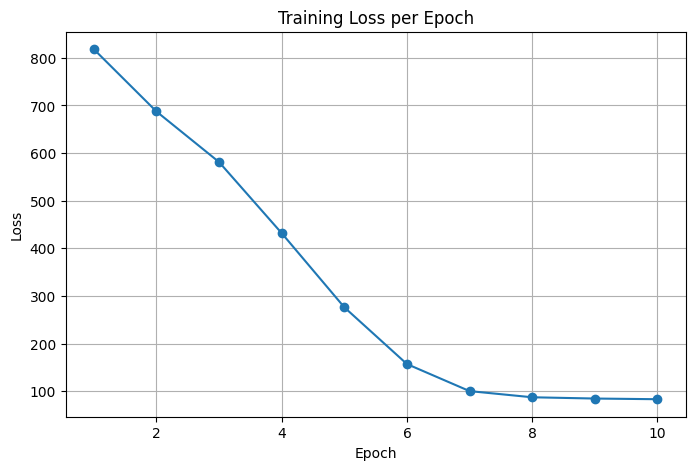

In [ ]:
# llama_student_train_with_loss_plot.py
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, LlamaConfig, LlamaForCausalLM
from torch.optim import AdamW
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

# ─── Hyperparameters & paths ─────────────────────────────────────────
DEVICE            = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE        = 8
EPOCHS            = 10
LR                = 5e-5
TEMPERATURE       = 2.0
TRAIN_LOGITS_PATHS = [
    "/content/drive/MyDrive/HPML/train_logits.pt",
    "/content/drive/MyDrive/HPML/train2_logits.pt",
    # "/content/drive/MyDrive/HPML/train1_logits.pt"
]
VAL_LOGITS_PATH   = "/content/drive/MyDrive/HPML/validation_logits.pt"
SAVE_DIR          = "/content/drive/MyDrive/HPML/test_0.5B"
ALPHA             = 0.5

# ─── Ensure save directory exists ────────────────────────────────────
os.makedirs(SAVE_DIR, exist_ok=True)

# ─── Load teacher logits + inputs ────────────────────────────────────
def load_logits(paths):
    input_ids_list = []
    attention_mask_list = []
    logits_list = []
    for path in paths:
        data = torch.load(path)
        input_ids_list.append(data["input_ids"])
        attention_mask_list.append(data["attention_mask"])
        logits_list.append(data["logits"])
    return (
        torch.cat(input_ids_list, dim=0),
        torch.cat(attention_mask_list, dim=0),
        torch.cat(logits_list, dim=0)
    )

train_input_ids, train_attention_mask, train_teacher_logits = load_logits(TRAIN_LOGITS_PATHS)
val_data = torch.load(VAL_LOGITS_PATH)
val_input_ids = val_data["input_ids"]
val_attention_mask = val_data["attention_mask"]
val_teacher_logits = val_data["logits"]

# ─── Dataset & DataLoader ────────────────────────────────────────────
class DistillDataset(Dataset):
    def __init__(self, input_ids, attention_mask, teacher_logits):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.teacher_logits = teacher_logits

    def __len__(self):
        return self.input_ids.size(0)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "teacher_logits": self.teacher_logits[idx],
        }

train_ds = DistillDataset(train_input_ids, train_attention_mask, train_teacher_logits)
val_ds = DistillDataset(val_input_ids, val_attention_mask, val_teacher_logits)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, pin_memory=True)

# ─── Build student LLaMA model ───────────────────────────────────────
teacher_cfg = LlamaConfig.from_pretrained("meta-llama/Llama-2-7b-hf")
student_cfg = LlamaConfig(
    vocab_size=teacher_cfg.vocab_size,
    hidden_size=1280,
    intermediate_size=3840,
    num_attention_heads=20,
    num_hidden_layers=24,
    rms_norm_eps=teacher_cfg.rms_norm_eps,
    pad_token_id=teacher_cfg.pad_token_id,
    bos_token_id=teacher_cfg.bos_token_id,
    eos_token_id=teacher_cfg.eos_token_id,
    tie_word_embeddings=True
)

student = LlamaForCausalLM(student_cfg).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
student.resize_token_embeddings(len(tokenizer))

# ─── Parameter count ─────────────────────────────────────────────────
print(f"Total parameters in student model: {sum(p.numel() for p in student.parameters()):,}")

# ─── Loss & optimizer ────────────────────────────────────────────────
criterion = nn.KLDivLoss(reduction="batchmean")
cross_entropy = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id, reduction="sum")
optimizer = AdamW(student.parameters(), lr=LR)

# ─── Evaluation fn ───────────────────────────────────────────────────
def evaluate(model, dataloader):
    model.eval()
    total_nll = total_tokens = top1 = top5 = 0
    with torch.no_grad():
        for batch in dataloader:
            ids = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            labs = ids.clone()
            out = model(input_ids=ids, attention_mask=mask).logits
            logits = out[:, :-1, :]; labs = labs[:, 1:]
            active = labs != tokenizer.pad_token_id
            loss_nll = cross_entropy(logits.reshape(-1, logits.size(-1)), labs.reshape(-1))
            total_nll += loss_nll.item()
            total_tokens += active.sum().item()
            preds = torch.topk(logits, k=5, dim=-1).indices
            top1 += (preds[:, :, 0] == labs).masked_select(active).sum().item()
            top5 += (preds == labs.unsqueeze(-1)).any(dim=-1).masked_select(active).sum().item()
    model.train()
    return math.exp(total_nll / total_tokens), top1 / total_tokens, top5 / total_tokens

# ─── Training loop ───────────────────────────────────────────────────
train_losses = []
wandb.init()
for epoch in range(EPOCHS):
    total_loss = 0
    steps = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for batch in pbar:
        ids = batch["input_ids"].to(DEVICE)
        mask = batch["attention_mask"].to(DEVICE)
        t_logits = batch["teacher_logits"].to(DEVICE)

        s_logits = student(input_ids=ids, attention_mask=mask).logits

        L = min(s_logits.size(1), t_logits.size(1))
        s_logits = s_logits[:, :L, :]
        t_logits = t_logits[:, :L, :]

        s_logp = nn.functional.log_softmax(s_logits / TEMPERATURE, dim=-1)
        t_p = nn.functional.softmax(t_logits / TEMPERATURE, dim=-1)

        kd_loss = criterion(s_logp, t_p) * (TEMPERATURE ** 2)

        labels = ids[:, 1:L+1]
        ce_logits = s_logits[:, :-1, :].contiguous()
        ce_loss = cross_entropy(ce_logits.view(-1, ce_logits.size(-1)), labels.reshape(-1))

        loss = ALPHA * kd_loss + (1 - ALPHA) * ce_loss
        wandb.log({"train/loss": loss.item(), "kd/loss": kd_loss.item(), "ce/loss": ce_loss.item()})
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        steps += 1
        pbar.set_postfix(train_loss=loss.item())

    train_losses.append(total_loss / steps)
    ppl, acc1, acc5 = evaluate(student, val_loader)
    wandb.log({"eval/ppl": ppl, "eval/top1-accuracy": acc1, "eval/top5-accuracy": acc5})
    print(f"\n→ Val PPL: {ppl:.2f} | Top-1: {acc1:.4f} | Top-5: {acc5:.4f}")

# ─── Save final model ────────────────────────────────────────────────
student.save_pretrained(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)
print(f"Student saved to {SAVE_DIR}")

# ─── Plot loss curve ────────────────────────────────────────────────
plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig(f"{SAVE_DIR}/training_loss_curve.png")
plt.show()


Total parameters in student model: 1,654,104,960


ce/loss,▅▂▃██▅▆▇▄▃▂▆▅▄▇▄▃▅▅▆▄▂▆▄▃▁▁▂▃▁▃▄▃▃▅▂▄▂▂▄
kd/loss,█▄▃▆▃▂▁▂▃▄▂▁▁▃▄▂▁▃▁▅▄▃▂▂▃▂▂▁▃▃▂▁▂▂▂▃▂▂▃▃
train/loss,▆▂▅▄▆▃█▄▆█▂▄█▄▃▇▂▆▃▃▆▂▅▃▅▁█▅▄▅▅▅▄▆▅▃▃▄▂▂
ce/loss,778.05579
kd/loss,94.0817
train/loss,436.06876


Epoch 1/10: 100%|██████████| 1250/1250 [09:09<00:00,  2.28it/s, train_loss=870]



→ Val PPL: 280.10 | Top-1: 0.2185 | Top-5: 0.3708


Epoch 2/10: 100%|██████████| 1250/1250 [09:08<00:00,  2.28it/s, train_loss=412]



→ Val PPL: 205.82 | Top-1: 0.2400 | Top-5: 0.3994


Epoch 3/10: 100%|██████████| 1250/1250 [09:08<00:00,  2.28it/s, train_loss=444]



→ Val PPL: 179.49 | Top-1: 0.2494 | Top-5: 0.4163


Epoch 4/10: 100%|██████████| 1250/1250 [09:09<00:00,  2.28it/s, train_loss=319]



→ Val PPL: 182.03 | Top-1: 0.2544 | Top-5: 0.4199


Epoch 5/10: 100%|██████████| 1250/1250 [09:08<00:00,  2.28it/s, train_loss=377]



→ Val PPL: 212.10 | Top-1: 0.2483 | Top-5: 0.4101


Epoch 6/10: 100%|██████████| 1250/1250 [09:08<00:00,  2.28it/s, train_loss=150]



→ Val PPL: 239.70 | Top-1: 0.2507 | Top-5: 0.4069


Epoch 7/10: 100%|██████████| 1250/1250 [09:09<00:00,  2.28it/s, train_loss=78.3]



→ Val PPL: 227.39 | Top-1: 0.2570 | Top-5: 0.4160


Epoch 8/10: 100%|██████████| 1250/1250 [09:08<00:00,  2.28it/s, train_loss=42.6]



→ Val PPL: 236.99 | Top-1: 0.2514 | Top-5: 0.4060


Epoch 9/10: 100%|██████████| 1250/1250 [09:09<00:00,  2.28it/s, train_loss=52.4]



→ Val PPL: 275.18 | Top-1: 0.2411 | Top-5: 0.3927


Epoch 10/10: 100%|██████████| 1250/1250 [09:08<00:00,  2.28it/s, train_loss=111]



→ Val PPL: 268.14 | Top-1: 0.2518 | Top-5: 0.3973
Student saved to /content/drive/MyDrive/HPML/test1


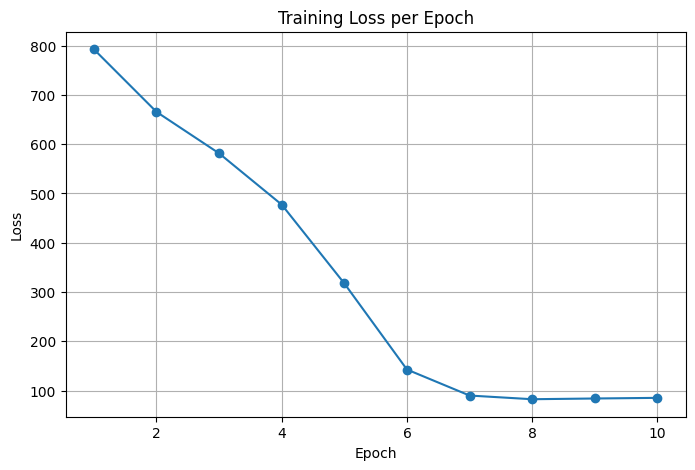

In [ ]:
# llama_student_train_with_loss_plot.py
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, LlamaConfig, LlamaForCausalLM
from torch.optim import AdamW
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

# ─── Hyperparameters & paths ─────────────────────────────────────────
DEVICE            = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE        = 8
EPOCHS            = 10
LR                = 5e-5
TEMPERATURE       = 2.0
TRAIN_LOGITS_PATHS = [
    "/content/drive/MyDrive/HPML/train_logits.pt",
    "/content/drive/MyDrive/HPML/train2_logits.pt",
    # "/content/drive/MyDrive/HPML/train1_logits.pt"
]
VAL_LOGITS_PATH   = "/content/drive/MyDrive/HPML/validation_logits.pt"
SAVE_DIR          = "/content/drive/MyDrive/HPML/test1"
ALPHA             = 0.5

# ─── Ensure save directory exists ────────────────────────────────────
os.makedirs(SAVE_DIR, exist_ok=True)

# ─── Load teacher logits + inputs ────────────────────────────────────
def load_logits(paths):
    input_ids_list = []
    attention_mask_list = []
    logits_list = []
    for path in paths:
        data = torch.load(path)
        input_ids_list.append(data["input_ids"])
        attention_mask_list.append(data["attention_mask"])
        logits_list.append(data["logits"])
    return (
        torch.cat(input_ids_list, dim=0),
        torch.cat(attention_mask_list, dim=0),
        torch.cat(logits_list, dim=0)
    )

# train_input_ids, train_attention_mask, train_teacher_logits = load_logits(TRAIN_LOGITS_PATHS)
# val_data = torch.load(VAL_LOGITS_PATH)
# val_input_ids = val_data["input_ids"]
# val_attention_mask = val_data["attention_mask"]
# val_teacher_logits = val_data["logits"]

# ─── Dataset & DataLoader ────────────────────────────────────────────
class DistillDataset(Dataset):
    def __init__(self, input_ids, attention_mask, teacher_logits):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.teacher_logits = teacher_logits

    def __len__(self):
        return self.input_ids.size(0)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "teacher_logits": self.teacher_logits[idx],
        }

train_ds = DistillDataset(train_input_ids, train_attention_mask, train_teacher_logits)
val_ds = DistillDataset(val_input_ids, val_attention_mask, val_teacher_logits)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, pin_memory=True)

# ─── Build student LLaMA model ───────────────────────────────────────
teacher_cfg = LlamaConfig.from_pretrained("meta-llama/Llama-2-7b-hf")
student_cfg = LlamaConfig(
    vocab_size=teacher_cfg.vocab_size,
    hidden_size=1920,
    intermediate_size=5120,
    num_attention_heads=30,
    num_hidden_layers=36,
    rms_norm_eps=teacher_cfg.rms_norm_eps,
    pad_token_id=teacher_cfg.pad_token_id,
    bos_token_id=teacher_cfg.bos_token_id,
    eos_token_id=teacher_cfg.eos_token_id,
    tie_word_embeddings=True
)

student = LlamaForCausalLM(student_cfg).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
student.resize_token_embeddings(len(tokenizer))

# ─── Parameter count ─────────────────────────────────────────────────
print(f"Total parameters in student model: {sum(p.numel() for p in student.parameters()):,}")

# ─── Loss & optimizer ────────────────────────────────────────────────
criterion = nn.KLDivLoss(reduction="batchmean")
cross_entropy = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id, reduction="sum")
optimizer = AdamW(student.parameters(), lr=LR)

# ─── Evaluation fn ───────────────────────────────────────────────────
def evaluate(model, dataloader):
    model.eval()
    total_nll = total_tokens = top1 = top5 = 0
    with torch.no_grad():
        for batch in dataloader:
            ids = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            labs = ids.clone()
            out = model(input_ids=ids, attention_mask=mask).logits
            logits = out[:, :-1, :]; labs = labs[:, 1:]
            active = labs != tokenizer.pad_token_id
            loss_nll = cross_entropy(logits.reshape(-1, logits.size(-1)), labs.reshape(-1))
            total_nll += loss_nll.item()
            total_tokens += active.sum().item()
            preds = torch.topk(logits, k=5, dim=-1).indices
            top1 += (preds[:, :, 0] == labs).masked_select(active).sum().item()
            top5 += (preds == labs.unsqueeze(-1)).any(dim=-1).masked_select(active).sum().item()
    model.train()
    return math.exp(total_nll / total_tokens), top1 / total_tokens, top5 / total_tokens

# ─── Training loop ───────────────────────────────────────────────────
train_losses = []
wandb.init()
for epoch in range(EPOCHS):
    total_loss = 0
    steps = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for batch in pbar:
        ids = batch["input_ids"].to(DEVICE)
        mask = batch["attention_mask"].to(DEVICE)
        t_logits = batch["teacher_logits"].to(DEVICE)

        s_logits = student(input_ids=ids, attention_mask=mask).logits

        L = min(s_logits.size(1), t_logits.size(1))
        s_logits = s_logits[:, :L, :]
        t_logits = t_logits[:, :L, :]

        s_logp = nn.functional.log_softmax(s_logits / TEMPERATURE, dim=-1)
        t_p = nn.functional.softmax(t_logits / TEMPERATURE, dim=-1)

        kd_loss = criterion(s_logp, t_p) * (TEMPERATURE ** 2)

        labels = ids[:, 1:L+1]
        ce_logits = s_logits[:, :-1, :].contiguous()
        ce_loss = cross_entropy(ce_logits.view(-1, ce_logits.size(-1)), labels.reshape(-1))

        loss = ALPHA * kd_loss + (1 - ALPHA) * ce_loss
        wandb.log({"train/loss": loss.item(), "kd/loss": kd_loss.item(), "ce/loss": ce_loss.item()})
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        steps += 1
        pbar.set_postfix(train_loss=loss.item())

    train_losses.append(total_loss / steps)
    ppl, acc1, acc5 = evaluate(student, val_loader)
    wandb.log({"eval/ppl": ppl, "eval/top1-accuracy": acc1, "eval/top5-accuracy": acc5})
    print(f"\n→ Val PPL: {ppl:.2f} | Top-1: {acc1:.4f} | Top-5: {acc5:.4f}")

# ─── Save final model ────────────────────────────────────────────────
student.save_pretrained(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)
print(f"Student saved to {SAVE_DIR}")

# ─── Plot loss curve ────────────────────────────────────────────────
plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig(f"{SAVE_DIR}/training_loss_curve.png")
plt.show()
